In [1]:
rm(list = ls());gc()
load("14_alt_pre.RData")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,807624,43.2,1533205,81.9,1244338,66.5
Vcells,1536792,11.8,8388608,64.0,2502269,19.1


Warning message:
“namespace ‘emmeans’ is not available and has been replaced
by .GlobalEnv when processing object ‘.Last.ref_grid’”


In [2]:
knitr::opts_chunk$set(echo = TRUE)

if(!require(poLCA)){install.packages("poLCA")}
if(!require(poLCAParallel)){devtools::install_github("QMUL/poLCAParallel@package")}
if(!require(compareGroups)){install.packages("compareGroups")}
if(!require(parallel)){install.packages("parallel")}
if(!require(Hmisc)){install.packages("Hmisc")}
if(!require(tidyverse)){install.packages("tidyverse")}
try(if(!require(sjPlot)){install.packages("sjPlot")})
if(!require(emmeans)){install.packages("emmeans")}
if(!require(nnet)){install.packages("nnet")}
if(!require(here)){install.packages("here")}
if(!require(doParallel)){install.packages("doParallel")}
if(!require(progress)){install.packages("progress")}
if(!require(caret)){install.packages("caret")}
if(!require(rpart)){install.packages("rpart")}
if(!require(rpart.plot)){install.packages("rpart.plot")}
if(!require(partykit)){install.packages("partykit")}
if(!require(randomForest)){install.packages("randomForest")}
if(!require(ggcorrplot)){install.packages("ggcorrplot")}
if(!require(polycor)){install.packages("polycor")}

#if(!require(poLCA)){githubinstall::gh_install_packages("poLCA", ref = github_pull("14"))}

#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
lca_dir<-here::here()
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#
#	
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:

tryNA <- function(x){
    x <- try(x)
    if(inherits(x,'try-error')) return(NA)
    x
}

#https://rdrr.io/github/hyunsooseol/snowRMM/src/R/lca.b.R
#https://github.com/dlinzer/poLCA/issues/7

#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#' Bivariate residuals for latent class models
#' 
#' Calculate the "bivariate residuals" (BVRs) between pairs of variables 
#' in a latent class model.
#' 
#' This function compares the model-implied (expected) counts in the crosstables
#' of all pairs of observed dependent variables to the observed counts. For each
#' pair, it calculates a "chi-square" statistic,
#' 
#' \deqn{\text{BVR} = \sum_{j, j'} \frac{(n_{jj'} - e_{jj'})^2}{e_{jj'}}},
#' 
#' where \eqn{n_{jj'}} are the observed counts for categories \eqn{j} and \eqn{j'} 
#' of the variables being crosstabulated, and \eqn{e_{jj'}} are
#' the expected counts under the latent class model. 
#' 
#' Note that the BVR does not follow an asymptotic chi-square distribution and
#' for accurate p-values, parametric bootstrapping is necessary (Oberski et al. 2013).
#' 
#' @param fit A poLCA fit object
#' @param tol Optional: tolerance for small expected counts
#' @param rescale_to_df Optional: whether to divide the pairwise "chi-square" values by 
#' the degrees of freedom of the local crosstable. Default is TRUE.
#' @return The table of bivariate residuals
#' @author Daniel Oberski (daniel.oberski@gmail.com)
#' @seealso \code{\link{poLCA}} for fitting the latent class model.
#' @references 
#' Oberski, DL, Van Kollenburg, GH and Vermunt, JK (2013). 
#'   A Monte Carlo evaluation of three methods to detect local dependence in binary data latent class models. 
#'   Advances in Data Analysis and Classification 7 (3), 267-279.
#' @examples
#' data(values)
#' f <- cbind(A, B, C, D) ~ 1
#' M0 <- poLCA(f,values, nclass=1, verbose = FALSE) 
#' bvr(M0) # 12.4, 5.7, 8.3, 15.6, ... 
bvr <- function(fit, tol = 1e-3, rescale_to_df = TRUE) {
  stopifnot(class(fit) == "poLCA")

  ov_names <- names(fit$predcell)[1:(ncol(fit$predcell) - 2)]
  ov_combn <- combn(ov_names, 2)

  get_bvr <- function(ov_pair) {
    form_obs <- as.formula(paste0("observed ~ ", ov_pair[1], " + ", ov_pair[2]))
    form_exp <- as.formula(paste0("expected ~ ", ov_pair[1], " + ", ov_pair[2]))

    counts_obs <- xtabs(form_obs, data = fit$predcell)
    counts_exp <- xtabs(form_exp, data = fit$predcell)
    counts_exp <- ifelse(counts_exp < tol, tol, counts_exp) # Prevent Inf/NaN

    bvr_df <- prod(dim(counts_exp) - 1)
    bvr_value <- sum((counts_obs - counts_exp)^2 / counts_exp)

    if(rescale_to_df) bvr_value <- bvr_value / bvr_df

    attr(bvr_value, "df") <- bvr_df

    bvr_value
  }

  bvr_pairs <- apply(ov_combn, 2, get_bvr)

  attr(bvr_pairs, "rescale_to_df") <- rescale_to_df
  attr(bvr_pairs, "class") <- "dist"
  attr(bvr_pairs, "Size") <- length(ov_names)
  attr(bvr_pairs, "Labels") <- ov_names
  attr(bvr_pairs, "Diag") <- FALSE
  attr(bvr_pairs, "Upper") <- FALSE

  bvr_pairs
}

#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
poLCA.entropy.fix <- function (lc)
{
  K.j <- sapply(lc$probs, ncol)
  fullcell <- expand.grid(sapply(K.j, seq, from = 1))
  P.c <- poLCA.predcell(lc, fullcell)
  return(-sum(P.c * log(P.c), na.rm = TRUE))
}

#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#Calculate entropy R2 for poLCA model

# MIT license
# Author: Daniel Oberski
# Input: result of a poLCA model fit
# Output: entropy R^2 statistic (Vermunt & Magidson, 2013, p. 71)
# See: daob.nl/wp-content/uploads/2015/07/ESRA-course-slides.pdf
# And: https://www.statisticalinnovations.com/wp-content/uploads/LGtecnical.pdf
machine_tolerance <- sqrt(.Machine$double.eps)
entropy.R2 <- function(fit) {
  entropy <- function(p) {
    p <- p[p > machine_tolerance] # since Lim_{p->0} p log(p) = 0
    sum(-p * log(p))
  }
  error_prior <- entropy(fit$P) # Class proportions
  error_post <- mean(apply(fit$posterior, 1, entropy))
  R2_entropy <- (error_prior - error_post) / error_prior
  R2_entropy
}

#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#http://researchdata.gla.ac.uk/879/1/Survey_data_processed_using_R.pdf
##Function to plot variable probabilites by latent class

## Function to undertake chisquare analayis and plot graphs of residuals and contributions
chisquaretest.predictions.function <-
 function(indfactor.data,
	 predclass.data,
	 noclasses,
	 pitem,
	 gitem,
	 chirows,
	 chicols) {
	 chisquare.results <- chisq.test(indfactor.data, predclass.data)
	 residuals.data <- chisquare.results$residuals
	 colnames(residuals.data) <- chicols
	 rownames(residuals.data) <- chirows
		 title.text <-
			 paste(
			 "Residuals: chi Square Crosstabulation of\n",
			 pitem,
			 "and",
			 gitem,
			 "\n(Chisquare =",
			 round(chisquare.results$statistic, 3),
			 " p <",
			 round(chisquare.results$p.value, 3),
			 ")",
			 sep = " "
			 )
		 corrplot(
			 residuals.data,
			 is.cor = FALSE,
			 title = title.text,
			 mar = c(0, 0, 4, 0)
			 )
		 contrib.data <-
		 100 * residuals.data ^ 2 / chisquare.results$statistic
		 round(contrib.data, 3)
		 colnames(contrib.data) <- chicols
		 rownames(contrib.data) <- chirows
		 title.text <-
		 paste(
			 "Contributions: chi Square Crosstabulation of\n",
			 pitem,
			 "and",
			 gitem,
			 "\n(Chisquare =",
			 round(chisquare.results$statistic, 3),
			 " p <",
			 round(chisquare.results$p.value, 3),
			 ")",
			 sep = " "
			 )
		 corrplot(
			 contrib.data,
			 is.cor = FALSE,
			 title = title.text,
			 mar = c(0, 0, 4, 0)
			 )
		 return(chisquare.results)
 }
##Funciton for Cramers V test
cv.test = function(x, y) {
	 CV = sqrt(chisq.test(x, y, correct = FALSE)$statistic /
	 (length(x) * (min(
	 length(unique(x)), length(unique(y))
	 ) - 1)))
	 print.noquote("Cramér V / Phi:")
	 return(as.numeric(CV))
	}

#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:

if(.Platform$OS.type == "windows") withAutoprint({
  memory.size()
  memory.size(TRUE)
  memory.limit(size=56000)
})

path<-try(dirname(rstudioapi::getSourceEditorContext()$path))

options(knitr.kable.NA = '')


#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:

knitr::knit_hooks$set(time_it = local({
  now <- NULL
  function(before, options) {
    if (before) {
      # record the current time before each chunk
      now <<- Sys.time()
    } else {
      # calculate the time difference after a chunk
      res <- ifelse(difftime(Sys.time(), now)>(60^2),difftime(Sys.time(), now)/(60^2),difftime(Sys.time(), now)/(60^1))
      # return a character string to show the time
      x<-ifelse(difftime(Sys.time(), now)>(60^2),paste("Time for this code chunk to run:", round(res,1), "hours"),paste("Time for this code chunk to run:", round(res,1), "minutes"))
      paste('<div class="message">', gsub('##', '\n', x),'</div>', sep = '\n')
    }
  }
}))
knitr::opts_chunk$set(time_it = TRUE)
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:
#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:#:

#to format rows in bold
format_cells <- function(df, rows ,cols, value = c("italics", "bold", "strikethrough")){

  # select the correct markup
  # one * for italics, two ** for bold
  map <- setNames(c("*", "**", "~~"), c("italics", "bold", "strikethrough"))
  markup <- map[value]  

  for (r in rows){
    for(c in cols){

      # Make sure values are not factors
      df[[c]] <- as.character( df[[c]])

      # Update formatting
      df[r, c] <- ifelse(nchar(df[r, c])==0,"",paste0(markup, gsub(" ", "", df[r, c]), markup))
    }
  }

  return(df)
}
#To produce line breaks in messages and warnings
knitr::knit_hooks$set(
   error = function(x, options) {
     paste('\n\n<div class="alert alert-danger">',
           gsub('##', '\n', gsub('^##\ Error', '**Error**', x)),
           '</div>', sep = '\n')
   },
   warning = function(x, options) {
     paste('\n\n<div class="alert alert-warning">',
           gsub('##', '\n', gsub('^##\ Warning:', '**Warning**', x)),
           '</div>', sep = '\n')
   },
   message = function(x, options) {
     paste('<div class="message">',
           gsub('##', '\n', x),
           '</div>', sep = '\n')
   }
)
#

Loading required package: poLCA

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘poLCA’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/poLCA_1.6.0.1.tar.gz' ...
	OK [downloaded 439 Kb in 0.3 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/scatterplot3d_0.3-43.tar.gz' ...
	OK [downloaded 348.2 Kb in 0.1 secs]
Installing scatterplot3d [0.3-43] ...
	OK [installed binary]
Moving scatterplot3d [0.3-43] into the cache ...
	OK [moved to cache in 0.34 milliseconds]
Installing poLCA [1.6.0.1] ...
	OK [installed binary]
Moving poLCA [1.6.0.1] into the cache ...
	OK [moved to cache in 0.28 milliseconds]


Loading required package: poLCAParallel

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘poLCAParallel’”



RcppArmad... (NA -> 0.12.0.1.0) [CRAN]


Installing 1 packages: RcppArmadillo

Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpLOJPJ2/remotesc425fce1c7/QMUL-poLCAParallel-80bc8a2/DESCRIPTION’ ... OK
* preparing ‘poLCAParallel’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘poLCAParallel_1.1.0.tar.gz’



Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)

Loading required package: compareGroups

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘compareGroups’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/compareGroups_4.6.0.tar.gz' ...
	OK [downloaded 3.2 Mb in 0.7 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/HardyWeinberg_1.7.5.tar.gz' ...
	OK [downloaded 1014 Kb in 1 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/mice_3.15.0.tar.gz' ...
	OK [downloaded 1.4 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/Rsolnp_1.16.tar.gz' ...
	OK [downloaded 242.9 Kb in 0.4 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/truncnorm_1.0-9.tar.gz' ...
	OK [downloaded 21.2 Kb in 0.3 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/writexl_1.4.2.tar.gz' ...
	OK [downloaded 151.8 Kb in 0.2 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/flextable_0.

Loading required package: parallel

Loading required package: Hmisc

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘Hmisc’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/Hmisc_5.0-1.tar.gz' ...
	OK [downloaded 3.2 Mb in 0.1 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/cluster_2.1.4.tar.gz' ...
	OK [downloaded 625.5 Kb in 0.1 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/htmlTable_2.4.1.tar.gz' ...
	OK [downloaded 406.1 Kb in 0.1 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/checkmate_2.1.0.tar.gz' ...
	OK [downloaded 704.3 Kb in 0.1 secs]
Installing cluster [2.1.4] ...
	OK [installed binary]
Moving cluster [2.1.4] into the cache ...
	OK [moved to cache in 0.28 milliseconds]
Installing checkmate [2.1.0] ...
	OK [installed binary]
Moving checkmate [2.1.0] into the cache ...
	OK [moved to cache in 0.31 milliseconds]
Installing htmlTable [2.4.1] ...
	OK [installed binary]
Moving htmlTable [2.4.1] into the cache ...
	OK [moved to cache 

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: sjPlot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘sjPlot’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/sjPlot_2.8.13.tar.gz' ...
	OK [downloaded 1.4 Mb in 0.4 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/bayestestR_0.13.0.tar.gz' ...
	OK [downloaded 1.4 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/insight_0.19.1.tar.gz' ...
	OK [downloaded 2 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/datawizard_0.7.0.tar.gz' ...
	OK [downloaded 1.1 Mb in 0.4 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/effectsize_0.8.3.tar.gz' ...
	OK [downloaded 691.6 Kb in 0.3 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/parameters_0.20.2.tar.gz' ...
	OK [downloaded 1.8 Mb in 0.4 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/performance

Loading required package: emmeans

Loading required package: nnet

Loading required package: here

here() starts at /work/files/workspace

Loading required package: doParallel

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘doParallel’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/doParallel_1.0.17.tar.gz' ...
	OK [downloaded 183.3 Kb in 0.1 secs]
Installing doParallel [1.0.17] ...
	OK [installed binary]
Moving doParallel [1.0.17] into the cache ...
	OK [moved to cache in 0.33 milliseconds]


Loading required package: progress

Loading required package: caret

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: rpart

Loading required package: rpart.plot

Loading required package: partykit

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/randomForest_4.7-1.1.tar.gz' ...
	OK [downloaded 256.8 Kb in 0.5 secs]
Installing randomForest [4.7-1.1] ...
	OK [installed binary]
Moving randomForest [4.7-1.1] into the cache ...
	OK [moved to cache in 0.37 milliseconds]


Loading required package: ggcorrplot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ggcorrplot’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/ggcorrplot_0.1.4.tar.gz' ...
	OK [downloaded 27.8 Kb in 0.1 secs]
Installing ggcorrplot [0.1.4] ...
	OK [installed binary]
Moving ggcorrplot [0.1.4] into the cache ...
	OK [moved to cache in 0.34 milliseconds]


Loading required package: polycor

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘polycor’”


Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/polycor_0.8-1.tar.gz' ...
	OK [downloaded 70.7 Kb in 0.4 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/admisc_0.31.tar.gz' ...
	OK [downloaded 335.2 Kb in 0.4 secs]
Installing admisc [0.31] ...
	OK [installed binary]
Moving admisc [0.31] into the cache ...
	OK [moved to cache in 0.27 milliseconds]
Installing polycor [0.8-1] ...
	OK [installed binary]
Moving polycor [0.8-1] into the cache ...
	OK [moved to cache in 0.27 milliseconds]
Error : RStudio not running


In [3]:
clus_iter=500
n_thread <- parallel::detectCores()
nrep <- clus_iter # number of different initial values (could be n_thread too)
n_class_max <- 12 # maximum number of classes to investigate
n_bootstrap <- 2 # 2x00 number of bootstrap samples
print(n_thread)

[1] 16


# LCA

## Specify model

0s were declared as missing data.


In [4]:
preds <- c("sex", "dg_trs_cons_sus_or",  "nombre_region", "sus_ini_mod_mvv", "escolaridad_rec", "freq_cons_sus_prin", "origen_ingreso_mod", "condicion_ocupacional_corr", "comorbidity_icd_10", "con_quien_vive_joel", "sus_principal_mod", "discrepancies")

mydata_preds <- Base_fiscalia_v13c_dic_2022_4%>% dplyr::mutate(across(preds, ~ as.numeric(factor(.))+1))%>% dplyr::mutate(across(preds, ~ dplyr::case_when(is.na(.)~ 1, T~ .))) 

#check 
#table(mydata_preds$sus_ini_mod_mvv, Base_fiscalia_v13c_dic_2022_4$sus_ini_mod_mvv, exclude=NULL)

f_preds<-cbind(sex, dg_trs_cons_sus_or, nombre_region, sus_ini_mod_mvv, escolaridad_rec, freq_cons_sus_prin, origen_ingreso_mod, condicion_ocupacional_corr, comorbidity_icd_10, con_quien_vive_joel, sus_principal_mod, discrepancies)~1
f_adj <- cbind(sex, dg_trs_cons_sus_or, nombre_region, sus_ini_mod_mvv, escolaridad_rec, freq_cons_sus_prin, origen_ingreso_mod, condicion_ocupacional_corr, comorbidity_icd_10, con_quien_vive_joel, sus_principal_mod)~discrepancies

#qdapTools::mtabulate(mydata_preds)
#glimpse(mydata_preds) #

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `across(preds, ~as.numeric(factor(.)) + 1)`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(preds)

  # Now:
  data %>% select(all_of(preds))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


Check collinearity running an heterogeneous matrix of correlations.

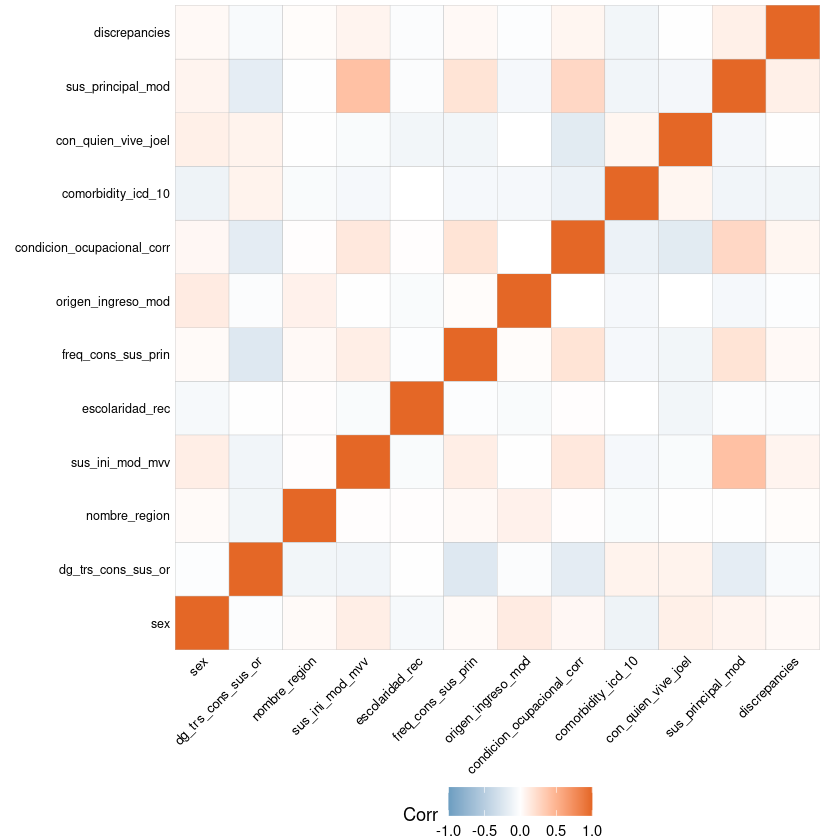

In [5]:
#glimpse(mydata_preds[,preds])
tiempo_antes_hetcor<-Sys.time()
hetcor_mat<-polycor::hetcor(data.table::data.table(mydata_preds[,preds]), ML = T, std.err =T, use="pairwise.complete.obs", bins=5, pd=TRUE)
tiempo_despues_hetcor<-Sys.time()
tiempo_hetcor<-tiempo_despues_hetcor-tiempo_antes_hetcor

hetcor_mat$tests[is.na(hetcor_mat$tests)]<-1

ggcorrplot<-
ggcorrplot::ggcorrplot(hetcor_mat$correlations,
           ggtheme = ggplot2::theme_void,
           insig = "blank",
           pch=1,
           pch.cex=3,
           tl.srt = 45, 
           #pch="ns",
            p.mat = hetcor_mat$tests, #  replacement has 144 rows, data has 169
            #type = "lower",
           colors = c("#6D9EC1", "white", "#E46726"), 
           tl.cex=8,
           lab=F)+
  #scale_x_discrete(labels = var_lbls_p345, drop = F) +
  #scale_y_discrete(labels = var_lbls_p345, drop = F) +
 #theme(axis.text.x = element_blank())+
  theme(axis.text.y = element_text(size=7.5,color ="black", hjust = 1))+
  #theme(axis.text.y = element_blank())+
  theme(legend.position="bottom")
ggcorrplot

#ggplotly(ggcorrplot, height = 800, width=800)%>% 
#  layout(xaxis= list(showticklabels = FALSE)) %>% 
# layout(annotations = 
# list(x = .1, y = -0.031, text = "", 
#      showarrow = F, xref='paper', yref='paper', 
#      #xanchor='center', yanchor='auto', xshift=0, yshift=-0,
#      font=list(size=11, color="darkblue"))
# )

In [6]:
#dropped region name because it was too different,many categories
preds2 <-c(setdiff(preds,c("sus_ini_mod_mvv","nombre_region","condicion_ocupacional_corr")),"edad_a_ap_top_num_cut", "macrozona", "numero_de_hijos_mod_bin","cond_ocup_rec")  

mydata_preds2 <- Base_fiscalia_v13c_dic_2022_4%>% dplyr::mutate(cond_ocup_rec= dplyr::case_when(condicion_ocupacional_corr == "Employed"~ 1, condicion_ocupacional_corr %in% c("Inactive", "No activity", "Not seeking for work")~ 2, condicion_ocupacional_corr %in% c("Unemployed","Looking for a job for the first time")~ 3, T~ NA_real_), edad_a_ap_top_num_cut= cut(edad_a_ap_top_num, 3), comorbidity_icd_10= dplyr::case_when(grepl("Two or more",comorbidity_icd_10)~"One",T~as.character(comorbidity_icd_10)), numero_de_hijos_mod_bin= dplyr::case_when(numero_de_hijos_mod>0~1,numero_de_hijos_mod==0~0,T~NA_real_)) %>% 
dplyr::mutate(across(preds2, ~ as.numeric(factor(.))+1))%>% dplyr::mutate(across(preds2, ~ dplyr::case_when(is.na(.)~ 1, T~ .)))  %>% dplyr::select(any_of(preds2)) #%>%  data.table::data.table(.)

#lapply(preds2, function(p) {prop.table(table(mydata_preds2[p]))})

#freq_cons_sus_prin
#origen_ingreso_mod 4
#comorbidity_icd_10 4
#con_quien_vive_joel 4
#sus_principal_mod 4
#condicion_ocupacional_corr 4 6
#table(Base_fiscalia_v13c_dic_2022_4$condicion_ocupacional_corr)

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `across(preds2, ~as.numeric(factor(.)) + 1)`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(preds2)

  # Now:
  data %>% select(all_of(preds2))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


Then we make a regression tree to analyze how variables related

In [7]:
#define train and test samples
set.seed(2125)
ind <- sample(x = 2, size = nrow(mydata_preds2), replace = T, prob = c(0.7, 0.3))
train <- mydata_preds2[ind == 1, ]
test <- mydata_preds2[ind == 2, ]

form_rf <- as.formula(paste("discrepancies ~ ", paste(c("sex", "dg_trs_cons_sus_or", "macrozona", "escolaridad_rec", "freq_cons_sus_prin", "origen_ingreso_mod", "cond_ocup_rec", "comorbidity_icd_10", "con_quien_vive_joel", "edad_a_ap_top_num_cut", "sus_principal_mod", "numero_de_hijos_mod_bin"), collapse="+ ")))

mod2.2 <- train(form_rf, data = train, method = 'rpart',
                tuneLength = 30, trControl = trainControl(method = 'repeatedcv',
                                                          repeats = 3))

mod2.2
mod2.2$finalModel

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


CART 

37917 samples
   12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 34125, 34125, 34125, 34126, 34125, 34125, ... 
Resampling results across tuning parameters:

  cp            RMSE       Rsquared    MAE      
  0.0002040155  0.4514768  0.02168226  0.3660763
  0.0002048899  0.4514667  0.02169373  0.3660941
  0.0002105115  0.4513677  0.02185831  0.3662329
  0.0002111969  0.4513601  0.02186699  0.3662500
  0.0002152734  0.4512528  0.02208814  0.3663304
  0.0002253894  0.4511426  0.02228216  0.3665693
  0.0002262576  0.4511418  0.02226774  0.3665917
  0.0002333655  0.4510955  0.02231457  0.3667497
  0.0002422875  0.4509844  0.02258863  0.3668002
  0.0002500630  0.4509353  0.02267215  0.3669286
  0.0002510909  0.4509121  0.02272818  0.3669232
  0.0002875710  0.4508411  0.02270784  0.3673366
  0.0002979281  0.4508244  0.02273020  0.3674632
  0.0002994564  0.4508155  0.02276123  0.3674590
  0.0003024134  0.4508118  0.02275

n= 37917 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 37917 7880.621000 2.247752  
    2) edad_a_ap_top_num_cut>=2.5 14000 2389.805000 2.184429  
      4) sus_principal_mod< 5.5 9754 1542.140000 2.162908  
        8) sex< 2.5 8022 1225.406000 2.153328  
         16) comorbidity_icd_10>=3.5 3734  501.582200 2.133369 *
         17) comorbidity_icd_10< 3.5 4288  721.041000 2.170709  
           34) escolaridad_rec>=1.5 4274  712.695600 2.169162 *
           35) escolaridad_rec< 1.5 14    5.214286 2.642857 *
        9) sex>=2.5 1732  312.588300 2.207275 *
      5) sus_principal_mod>=5.5 4246  832.769900 2.233867  
       10) sex< 2.5 3298  611.718900 2.215585 *
       11) sex>=2.5 948  216.113900 2.297468 *
    3) edad_a_ap_top_num_cut< 2.5 23917 5401.818000 2.284818  
      6) comorbidity_icd_10>=3.5 9048 1833.328000 2.236406  
       12) sus_principal_mod< 4.5 4858  894.305500 2.201729  
         24) dg_trs_cons_sus_or>=2.5 1912  315.777700 2.166841 *
      

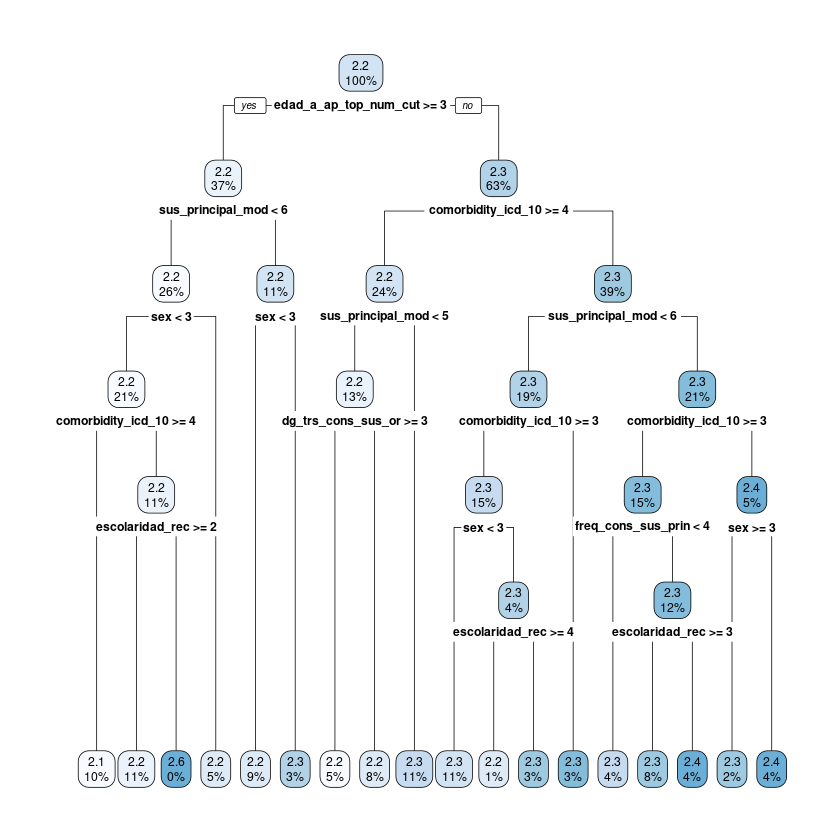

In [8]:
rpart.plot(mod2.2$finalModel)

We ended selecting less variables in order to restrict the analysis to drug use patterns

In [9]:
mydata_preds3 <-
  mydata_preds2 %>% 
dplyr::select(-macrozona, -cond_ocup_rec, -origen_ingreso_mod, -con_quien_vive_joel, -numero_de_hijos_mod_bin) %>%
  data.table::data.table(.)

save(mydata_preds3, file="14_alt2_pre.RData")

>Then we transformed into the variables that `poLCA` uses

In [10]:
f_preds2<-cbind(sex, dg_trs_cons_sus_or, macrozona, escolaridad_rec, freq_cons_sus_prin, origen_ingreso_mod, cond_ocup_rec, comorbidity_icd_10, con_quien_vive_joel, edad_a_ap_top_num_cut, sus_principal_mod, numero_de_hijos_mod_bin, discrepancies)~1
f_adj2 <- cbind(sex, dg_trs_cons_sus_or, macrozona, escolaridad_rec, freq_cons_sus_prin, origen_ingreso_mod, cond_ocup_rec, comorbidity_icd_10, con_quien_vive_joel, numero_de_hijos_mod_bin, edad_a_ap_top_num_cut, sus_principal_mod)~discrepancies

f_preds3<-cbind(sex, dg_trs_cons_sus_or, escolaridad_rec, freq_cons_sus_prin, comorbidity_icd_10, edad_a_ap_top_num_cut, sus_principal_mod, discrepancies)~1
f_adj3 <- cbind(sex, dg_trs_cons_sus_or, escolaridad_rec, freq_cons_sus_prin, comorbidity_icd_10, edad_a_ap_top_num_cut, sus_principal_mod)~discrepancies


We ran a parallelized version of `poLCA` analysis.

In [26]:
#Biemer, P. P., & Wiesen, C. (2002). Measurement error evaluation of self-reported drug use: a latent class analysis of the US National Household Survey on Drug Abuse. Journal of the Royal Statistical Society: Series A (Statistics in Society), 165(1), 97–119. doi:10.1111/1467-985x.00612  
#lca_entropia(x="ppio", seed= 2125, k= 8, f= f_preds, dat= mydata_preds, nbr_repet= 30, na_rm= T)
#3
#<div style="border: 1px solid #ddd; padding: 5px; overflow-y: scroll; height:400px; overflow-x: scroll; width:100%">
# f is the selected variables
# dat is the data
# nb_var is the number of selected variables
# k is the number of latent class generated
# nbr_repet is the number of repetition to  
# reach the convergence of EM algorithm
# x es el código para las variables de los modelos
#seed es el numero random para las semillas. ej: 4345.
#Modo de calcular el mejor modelo.
#z_ # 
#2023-01-20
#https://github.com/QMUL/poLCAParallel/blob/master/exec/3_blrt.R
#0h s
seed<-2125
old <- Sys.time()

require(progress)

set.seed(seed)
model_array <- list()  # Initialize an empty list to store the results
pb <- progress_bar$new(total = n_class_max, message_class = "Running poLCA")

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
for (k in 1:n_class_max) {
  nrep_int <- nrep  # Initialize nrep to a reasonable value
  while (nrep_int >= 1) {  # Try running poLCA with decreasing nrep until nrep reaches 1
    tryCatch({
      set.seed(seed)
      mod <- poLCAParallel::poLCA(
        f_preds3, 
        mydata_preds3,
        nclass = k, 
        nrep = nrep_int, 
        maxiter = 1e4,
        n.thread = 12,
        verbose = FALSE
      )
      model_array[[k]] <- mod  # Store the result if no error occurs
      break  # Exit the loop if poLCA succeeds
    }, error = function(e) {
      message(paste("Error in poLCA for k =", k, ", nrep =", nrep_int, ":", conditionMessage(e)))
      nrep_int <- nrep_int / 2  # Reduce nrep by half if poLCA fails
    })
  }
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_  
  pb$tick()  # Increment the progress bar
  cat(sprintf("\r%d%% completed", round(k/n_class_max*100)))  # Print progress percentage
  Sys.sleep(.05)
}

pb$terminate()  # Close the progress bar
cat(': Done')  # Print "Done" message  
                    
model_array_ppio<-model_array

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#BOOTSTRAP#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_

new_med<-(Sys.time())
paste0("The model took ",round(new_med-old,2)," hours until every LCA was computed")


In [ ]:
save.image("14_alt2_pre2.RData")

In [ ]:
invisible("")
# store p values for each nclass, 1 to n_class_max
# store 0 for 1 number of class, ie this says you cannot have zero number of
# classes
p_value_array <- c(0)
# for all number of classes investigated:
#   - store the log likelihood ratio
#   - store all bootstrap samples log likelihoods ratios
fitted_log_ratio_array <- rep(NaN, n_class_max)
bootstrap_log_ratio_array <- list()

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
# do the bootstrap likelihood ratio test for each number of classes
for (nclass in 2:n_class_max) {

  # get the null and alt models
  # these are models with one number of class differences
  null_model <- model_array[[nclass - 1]]
  alt_model <- model_array[[nclass]]

  # for each bootstrap sample, store the log likelihood ratio here
  bootstrap_results <- poLCAParallel::blrt(
    null_model, alt_model,
    n_bootstrap, n_thread, nrep
  )

  # log likelihood ratio to compare the two models
  fitted_log_ratio_array[nclass] <- bootstrap_results[["fitted_log_ratio"]]
  # store the log likelihoods ratios for all bootstrap samples
  bootstrap_log_ratio_array[[nclass]] <-
    bootstrap_results[["bootstrap_log_ratio"]]
  # store the p value for this nclass
  p_value_array <- c(p_value_array, bootstrap_results[["p_value"]])
  
  #progress bar
  cat(paste0(round(nclass / n_class_max * 100), '% completed'))
  Sys.sleep(.05)
  if (nclass == n_class_max) cat(': Done')
  else cat('\014')
}
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
new<-(Sys.time())
time_diff <- (Sys.time() - old)/60
paste0("The model took ",round(new-old,2)," minutes")

model_array_ppio2 <- model_array
fitted_log_ratio_array_ppio <- fitted_log_ratio_array
bootstrap_log_ratio_array_ppio <- bootstrap_log_ratio_array
bootstrap_results_ppio <- bootstrap_results
p_value_array_ppio <- p_value_array

# Get the BIC values for all models in model_array_ppio2
bic_values <- sapply(model_array_ppio2, function(model) model$bic)

# Identify the index of the model with the lowest BIC
best_model_index <- which.min(bic_values)

# Select the best model
LCA_best_model_ppio <- model_array_ppio2[[best_model_index]]
#####################################################################################################################################################################
#Within poLCA, parameter estimates are obtained by a procedure that repeatedly improves estimates.
#This is stopped when no further improvements are obtained, or until a maximum number of iterations is reached. The starting values are the values at which such repetitions were started. Increasing the number 4 R. ACHTERHOF ET AL.of iterations (cycles within each estimation) and setting more different starting values for each repetition results in a greater likelihood that the global (rather than local) maximum of the log-likelihood function (and thus, the best possible solution) is reached. The maximum number of iterations was chosen as 10.000, and 500 different sets of starting values were used (thus going beyond the recommendations by Linzer & Lewis, 2011; Oberski, 2016). As such, the influence of chance was minimized while the reproducibility of the results was maximized# 
                     

In [27]:
print(model_array_ppio) #

Then we exported the results into a graphic

In [28]:
relative.entropy<-function(lc){
  en<--sum(lc$posterior*
             log(lc$posterior),na.rm=T)
  e<-1-en/(nrow(lc$posterior)*log(ncol(lc$posterior)))
  return(e)
}
machine_tolerance <- sqrt(.Machine$double.eps)
entropy.R2 <- function(fit) {
  entropy <- function(p) {
    p <- p[p > machine_tolerance] # since Lim_{p->0} p log(p) = 0
    sum(-p * log(p))
  }
  error_prior <- entropy(fit$P) # Class proportions
  error_post <- mean(apply(fit$posterior, 1, entropy))
  R2_entropy <- (error_prior - error_post) / error_prior
  R2_entropy
}

# "log-likelihood": The log-likelihood of the model is computed by mod$llik.
# "Chi2": The chi-squared test statistic for the model is computed by mod$Chisq.
# "Chi2_pval": The p-value for the chi-squared test is computed by mod$Chisq.pvalue.
# "resid. df": The residual degrees of freedom for the model is computed by mod$resid.df.
# "AIC" : Akaike Information Criterion computed by mod$aic.
# "BIC": The Bayesian Information Criterion for the model is computed by mod$bic.
# "aBIC": The adjusted Bayesian Information Criterion for the model is computed by (-2*mod$llik) + (log((mod$N + 2)/24) * mod$npar).
# "cAIC": The consistent Akaike Information Criterion for the model is computed by (-2*mod$llik) + mod$npar * (1 + log(mod$N)). Making AIC asymptotically coherent
# "likelihood-ratio": The likelihood-ratio test statistic for the model is computed by mod$Gsq.
# "LLik_pval": The p-value for the likelihood-ratio test is computed by mod$Gsq.pvalue.
# "Entropy": The entropy of the model, which is a measure of the quality of classification, is computed by the relative.entropy() function.
# "Entropy.R2": The proportion of variance in the data accounted for by the model entropy is computed by the entropy.R2() function.
# "Dev Change": The change in deviance (G-squared) from the previous model in model_array_ppio2 is computed by (mod_min1$Gsq - mod$Gsq).
# "df": The number of degrees of freedom for the model is computed by mod$C^mod$I - mod$npar - 1.
# "pval": The p-value for the deviance change test is computed by pchisq(mod_min1$Gsq - mod$Gsq, mod_min1$resid.df - mod$resid.df).
#  "BLRT": log-likelihood ratio between the null(nclass -1 ) and alternative models
#  "BLRT.pvalue": p-value for the og-likelihood ratio test between the null(nclass -1 ) and alternative models

# Initialize an empty data frame
tab_ppio <- data.frame()

# Loop through each model
for (i in 2:n_class_max) {
  skip_to_next <- FALSE

  # Get the model and the previous model
  mod <- model_array_ppio2[[i]]
  mod_min1 <- model_array_ppio2[[(i-1)]]

  # Check if the model has valid predictions
  if (is.null(mod$predclass)) {
    skip_to_next <- TRUE
  }

  # If the model has valid predictions, calculate the measures and add them to the data frame
  if (!skip_to_next) {
    # Number of latent classes
    mod$C <- max(t(matrix(apply(mod$y, 2, max))))
    # Number of manifest variables
    mod$J <- ncol(mod$y)
    # Total number of items
    mod$I <- mod$J * mod$C
    # Degrees of freedom
    mod$df <- mod$C^mod$I - mod$npar - 1
    # Chi-square test
    mod$Chisq.pvalue <- (1 - pchisq(mod$Chisq, mod$df))
    # AIC
    mod$aic <- round(mod$aic, 2)
    # BIC
    mod$bic <- round(mod$bic, 2)
    # Adjusted BIC
    mod$aBIC <- round((-2 * mod$llik) + (log(mod$N) * mod$npar), 2)
    # Conditional AIC
    mod$cAIC <-  round((-2 * mod$llik) + (2 * mod$Nobs * log(mod$N/mod$Nobs)), 2)
    # Gsq: deviance
    mod$Gsq
    # Likelihood ratio test
    mod$Gsq.pvalue <- (1 - pchisq(mod$Gsq, mod$df))
    # Relative entropy
    mod$RelEnt <- round(relative.entropy(mod), 2)
    # Entropy R-squared
    mod$EntR2 <- round(entropy.R2(mod), 2)
    # Deviance change
    mod$DevChange <- round(mod_min1$Gsq - mod$Gsq, 2)
    # Degrees of freedom change
    mod$dfChange <- mod_min1$resid.df - mod$resid.df
    # P-value for deviance change
    mod$pvalDevChange <- round(pchisq(mod$DevChange, mod$dfChange, lower.tail = FALSE), 4)
    mod$BLRT <- round(fitted_log_ratio_array_ppio[[i]],2)
    mod$BLRT.pvalue <- p_value_array_ppio[[i]]
    # Add the model index to the data frame
    mod$ModelIndex <- i
      # Check if the data.frame is empty or has the same number of columns as mod
      #if (nrow(tab_ppio) == 0 || ncol(tab_ppio) == ncol(mod)) {
      # Add the measures to the data frame
    tab_ppio <- rbind.data.frame(tab_ppio, t(data.matrix(mod[c("llik", "Chisq", "Chisq.pvalue", "resid.df", "aic", "bic", "aBIC", "cAIC", "Gsq", "Gsq.pvalue", "RelEnt", "EntR2", "DevChange", "dfChange", "pvalDevChange", "ModelIndex","BLRT", "BLRT.pvalue")])))

    #  } else {}
  }
}

# identify the list-like columns
list_cols <- sapply(tab_ppio, is.list)
# unlist the list-like columns
unlisted_cols <- lapply(tab_ppio[list_cols], unlist)
# bind the unlisted columns as a data frame
tab_ppio <- cbind(tab_ppio[!list_cols], do.call(cbind, unlisted_cols))
#Erase rownames
rownames(tab_ppio) <- NULL



manualcolors <- c('indianred1', 'cornflowerblue', 'gray50', 'darkolivegreen4', 'slateblue2', 
                  'firebrick4', 'goldenrod4')
levels <- c("llik", "Chisq", "Chisq.pvalue", "resid.df", "aic", "bic", "aBIC", "cAIC",
            "Gsq", "Gsq.pvalue", "RelEnt", "EntR2", "DevChange", "dfChange",
            "pvalDevChange", "BLRT", "BLRT.pvalue")
labels <- c('Log-Likelihood', 'Chi2', 'p value Chi2', 'Degrees of Freedom', 
            'Akaike Information\nCriterion (AIC)', 'Bayesian Information\nCriterion (BIC)', 
            'Adjusted BIC', "Corrected AIC",'G-squared', 'p value G-squared', 'Relative Entropy', 
            'Entropy R2', 'Deviance Change\n(with previous model)', 'Degrees of Freedom Change',
            'p value Deviance Change', 'BLRT', 'BLRT p-value')

tab_ppio %>%
  dplyr::mutate_if(is.character, as.numeric) %>%  # convert character columns to numeric
  tidyr::pivot_longer(cols = -ModelIndex, #"evryone but index"
                       names_to = "indices", values_to = "value", values_drop_na = F) %>%
  dplyr::mutate(indices = factor(indices, levels = levels, labels = labels)) %>%
  dplyr::filter(grepl("(AIC|BIC)",indices, ignore.case=T))%>%
  ggplot(aes(x = ModelIndex, y = value, group = indices, color = indices, linetype = indices)) +
  geom_line(size = 1.5) +
  scale_color_manual(values = manualcolors) +
  #scale_linetype_manual(values = c("solid", "dashed", "dotted")) +
  labs(x = "Number of Classes", y = "Value", color = "Measure", linetype = "Measure") +
  #facet_wrap(.~indices, scales = "free_y", nrow = 4, ncol = 1) +
  theme_bw()

#lca_selectnaq %>% dplyr::arrange(BIC) 

#International Journal of Workplace Health Management  (Zhang et al., 2018).

And then into a table

In [29]:
tab_ppio %>%
  dplyr::select(ModelIndex, everything()) %>% 
    dplyr::mutate_if(is.character, as.numeric) %>%  # convert character columns to numeric
  knitr::kable(format="html", caption="Fit measures of models")

In [11]:
save.image("14_alt2.RData")

In [2]:
require(tidyverse)
sesion_info <- devtools::session_info()
dplyr::select(
  tibble::as_tibble(sesion_info$packages),
  c(package, loadedversion, source)
) %>% 
  DT::datatable(filter = 'top', colnames = c('Row number' =1,'Variable' = 2, 'Percentage'= 3),
              caption = htmltools::tags$caption(
        style = 'caption-side: top; text-align: left;',
        '', htmltools::em('Packages')),
      options=list(
initComplete = htmlwidgets::JS(
        "function(settings, json) {",
        "$(this.api().tables().body()).css({
            'font-family': 'Helvetica Neue',
            'font-size': '50%', 
            'code-inline-font-size': '15%', 
            'white-space': 'nowrap',
            'line-height': '0.75em',
            'min-height': '0.5em'
            });",#;
        "}")))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


HTML widgets cannot be represented in plain text (need html)